In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

import xgboost as xgb

In [2]:
# Load in dataset
df = pd.read_csv('train.csv')

Index(['id', 'trans_num', 'trans_date', 'trans_time', 'unix_time', 'category',
       'amt', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'merchant', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')


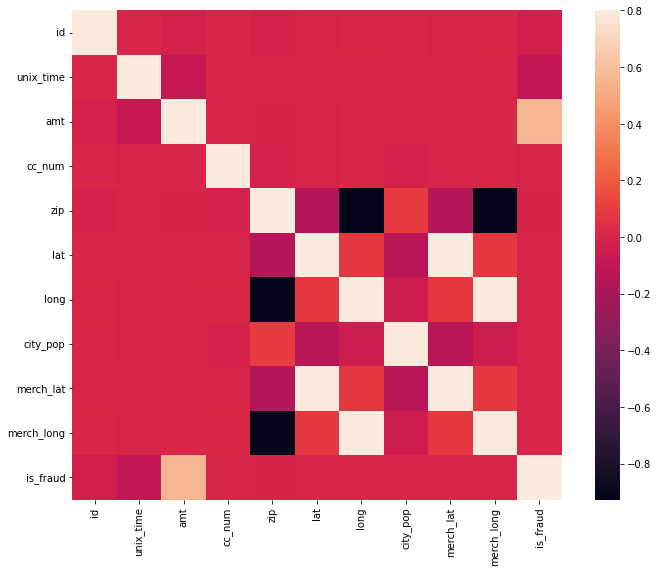

15784

In [3]:
# Explore dataset
print(df.columns)
pd.to_datetime(df.trans_date)
categorical_columns = df.select_dtypes(include='object')

corrmat = df.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

(df['first'] + df['last']).nunique()

In [4]:
# Get data as features and regressors and split into training and validation
Y=df.is_fraud
X = df.drop(columns=['is_fraud'])
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1)

In [5]:
# Feature engineering
def get_features(df):
    # Drop irrelevant columns
    cat_vars_to_drop = ['trans_num', 'dob', 'first', 'last', 'cc_num', 'id', 'street', 'city','state', 'zip', 'job']
    df_transformed = df.drop(columns = cat_vars_to_drop)
    
    
    # Handle transaction date variables (all 2024)
    df_transformed.trans_date = pd.to_datetime(df_transformed.trans_date)
    df_transformed['month'] = df_transformed['trans_date'].dt.month
    df_transformed['day'] = df_transformed['trans_date'].dt.day
    df_transformed['weekday'] = df_transformed['trans_date'].dt.weekday.astype('category')  # 0 = Monday, 6 = Sunday
    df_transformed = df_transformed.drop(columns = ['trans_date'])
    
    # Handle transaction time - keep as ordinal values
    df_transformed.trans_time = pd.to_datetime(df_transformed.trans_time)
    df_transformed['hour'] = df_transformed['trans_time'].dt.hour
    df_transformed['minute'] = df_transformed['trans_time'].dt.minute
    df_transformed = df_transformed.drop(columns = ['trans_time'])
    
    # One-hot encode other categorical variables of interest
    cat_vars_to_encode = ['category', 'merchant', 'gender']
    df_transformed['category'] = df_transformed['category'].astype('category')
    df_transformed['merchant'] = df_transformed['merchant'].astype('category')
    df_transformed['gender'] = df_transformed['gender'].astype('category')
    
    
    return df_transformed

In [6]:
# Feature engineering
features_train = get_features(X_train)

In [7]:
# Train XGBoost classification model
clf = xgb.XGBClassifier(n_estimators = 1000,
                        random_state=42, 
                        max_depth = 8,
                        subsample = .7, 
                        eval_metric = f1_score, 
                        alpha = 0.5,
                        enable_categorical=True,
                        tree_method = 'approx',
                        base_score=.5,
                       objective = 'binary:logistic')
clf.fit(features_train, Y_train)

XGBClassifier(alpha=0.5, base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True,
              eval_metric=<function f1_score at 0x7fe2ab914f70>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [12]:
# Compute training accuracy
preds_train = clf.predict(features_train)
f1_train = f1_score(Y_train, preds_train)
print('F1 score on training set: ', f1_train)

# Compute validation accuracy
features_val = get_features(X_val)
preds_val = clf.predict(features_val)
f1_val = f1_score(Y_val, preds_val)
print('F1 score on validation set: ', f1_val)

F1 score on training set:  1.0
F1 score on validation set:  1.0


In [11]:
# Train on everything before submitting
clf.fit(get_features(X),Y)


XGBClassifier(alpha=0.5, base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True,
              eval_metric=<function f1_score at 0x7fe2ab914f70>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [13]:
# Testing
X_test = pd.read_csv('test.csv')
features_test = get_features(X_test)
test_preds = clf.predict(features_test)

# Convert to csv file
submission = pd.DataFrame({'id': X_test.id, 'is_fraud':test_preds})
submission.to_csv('submission_experiments.csv', index=False)

In [188]:
# Current best submission. DO NOT MODIFY